# INF343 : TP1 Perceptron 

#### Importation des libarairies

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns
from matplotlib import rc

#### Displaying labeled data

In [2]:
symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'axes.grid': False,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

## Execice 1 : Génération artificielle de données

#### Data Generation

In [4]:
def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """Sample  points from a Gaussian variable.

    Parameters
    ----------
    n : number of samples

    mu : centered

    sigma : standard deviation
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(mu + res * sigmas)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """Sample points from two Gaussian distributions.

    Parameters
    ----------
    n1 : number of sample from first distribution

    n2 : number of sample from second distribution

    mu1 : center for first distribution

    mu2 : center for second distribution

    sigma1: std deviation for first distribution

    sigma2: std deviation for second distribution
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """Create samples and labels form a **clown** dataset.

    Parameters
    ----------
    n1 : number of sample from first blob

    n2 : number of sample from second blob

    sigma1 :  noise std deviation for the first blob

    sigma2 :  noise std deviation for the second blob
    """
    x0 = np.random.randn(n1, 1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1, 1)
    x2 = np.hstack([sigma2 * np.random.randn(n2, 1),
                    sigma2 * np.random.randn(n2, 1) + 2.])
    X = np.vstack([np.hstack([x0, x1]), x2])
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_checkers(n1=100, n2=100, sigma=0.1):
    """Create samples and labels from a noisy checker.

    Parameters
    ----------
    n1 : number of samples for the first class

    n2 : number of samples for the second class
    """
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [-1] * nb

            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.random.permutation((nbp + nbn) * 8)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])


#### Question 1 :

Générer ensuite plusieurs jeux de données à l’aide des fonctions rand_bi_gauss, rand_clown et rand_checkers pour différents paramètres d’entrée n,mu,sigma. 

Que renvoient ces fonctions ? À quoi correspond la seconde variable de sortie ?

#### Fonction pour plot les données

In [35]:
def plot_2d(X, y, w=None, step=50, alpha_choice=1):
    """2D dataset data ploting according to labels.

    Parameters
    ----------

    X : data features

    y : label vector

    w :(optional) the separating hyperplan w

    alpha_choice : control alpha display parameter
    """
    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("deep", k)
    sns.set_palette(color_blind_list)
    for i, label in enumerate(y):
        label_num = np.where(labels == label)[0][0]
        plt.scatter(X[i, 0], X[i, 1],
                    c=np.reshape(color_blind_list[label_num], (1, -1)),
                    s=80, marker=symlist[label_num])
    plt.xlim([min_tot0 - delta0 / 10., max_tot0 + delta0 / 10.])
    plt.ylim([min_tot1 - delta1 / 10., max_tot1 + delta1 / 10.])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

#### rand_bi_gauss function

In [36]:
X_1, Y_1 = rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1])
print(X_1)
print(Y_1)

[[-1.0230827  -1.09541835]
 [-0.99725702 -0.90349514]
 [ 0.99292219  0.77057972]
 [-1.03624902 -1.17599121]
 [ 0.94682909  0.98811723]
 [-1.04872213 -0.88601105]
 [ 1.01603816  1.02040871]
 [ 0.96415269  0.93482935]
 [ 0.93738503  1.03945614]
 [-1.01790954 -0.87046935]
 [ 1.05183338  1.11647184]
 [-1.08505591 -1.05114819]
 [ 0.84222729  1.04379607]
 [-0.79493434 -1.22396457]
 [ 1.05241802  1.05761561]
 [ 1.08068009  0.96155171]
 [-0.87596273 -0.97085132]
 [-1.0453748  -0.98591976]
 [-1.04152093 -0.96488141]
 [-0.93479106 -0.98116183]
 [ 1.04304298  0.99406978]
 [ 1.02046527  1.12759482]
 [-0.90711106 -0.98965122]
 [ 1.08089994  1.03073314]
 [ 1.03476686  1.20427515]
 [-0.97543313 -0.99013813]
 [-1.05400622 -0.95570154]
 [ 0.84896056  1.0830983 ]
 [-0.97655652 -0.87577507]
 [-1.09769777 -1.08969483]
 [-1.11764687 -1.04613784]
 [-1.0454934  -0.98028484]
 [ 1.06863025  0.96444609]
 [-1.06541673 -1.01791397]
 [ 0.95940108  0.9594566 ]
 [ 0.98575239  0.86226926]
 [ 0.98471169  1.14173808]
 

Text(0.5, 1.0, 'rand_bi_gauss function \n')

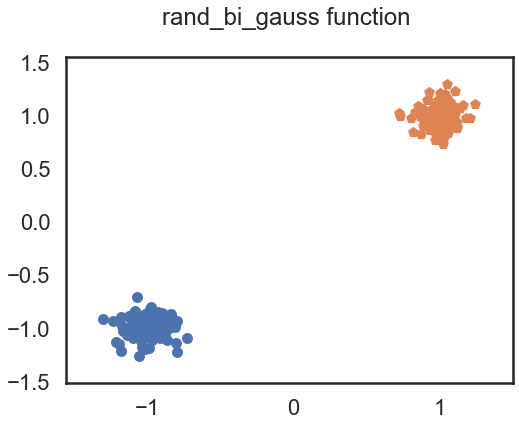

In [37]:
plot_2d(X_1, Y_1)
plt.title("rand_bi_gauss function \n")

#### rand_clown function

In [38]:
X_2, Y_2 = rand_clown(n1=100, n2=100, sigma1=1, sigma2=2)


Text(0.5, 1.0, 'rand_clown function \n')

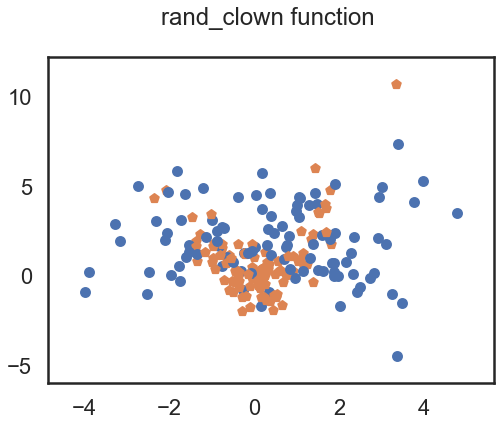

In [39]:
plot_2d(X_2, Y_2)
plt.title("rand_clown function \n")

#### rand_checkers function

In [42]:
X_3, Y_3 = rand_checkers(n1=100, n2=100, sigma=0.1)

Text(0.5, 1.0, 'rand_clown function \n')

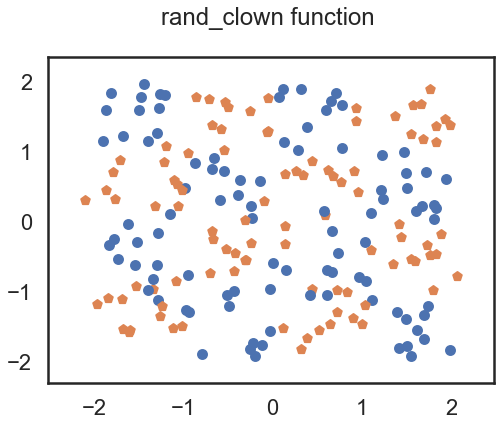

In [43]:
plot_2d(X_3, Y_3)
plt.title("rand_clown function \n")

#### Ces 3 fonctions génèrent pour la première variable de sortie aléatoirement un ensemble de points d'observation (data points) de manière aléatoire. 
#### La seconde variable générée par ces 3 fonctions correspond au label des points d'observations

### Exercice 2 : Le Perceptron

#### Question 1 : On cherche à la main une ligne séparatrice pour les 3 jeu de données

### Cas rand_bi_gauss function

Text(0.5, 1.0, 'rand_bi_gauss function \n')

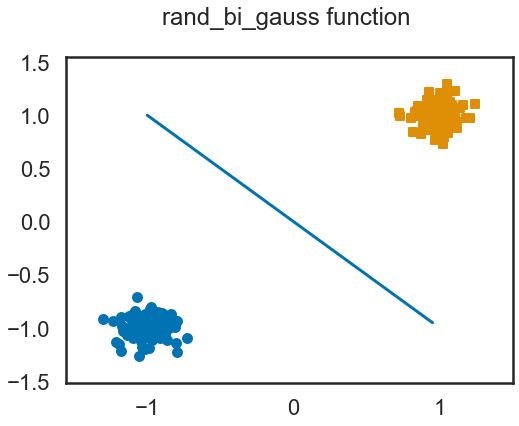

In [134]:
plot_2d(X_1, Y_1)
plt.plot(np.arange(-2, 2, 0.1)*0.5, np.arange(-2, 2, 0.1)*(-0.5))
plt.title("rand_bi_gauss function \n")

### Cas rand_clown function

Text(0.5, 1.0, 'rand_clown function \n')

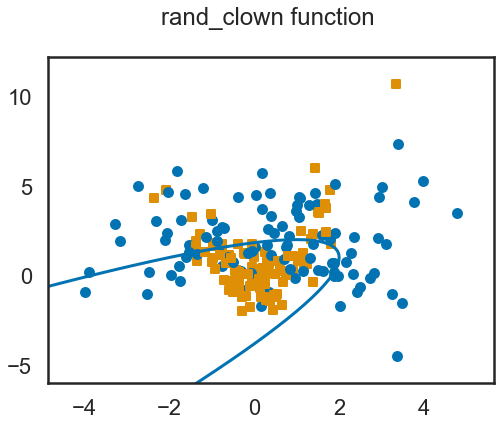

In [161]:
plot_2d(X_2, Y_2)
x1 = np.arange(-4, 6, 0.1)
x2 = np.arange(-5, 5, 0.1)
plt.plot(-x1**2 + 2*x1 + 1 , -x2**2 + 2*x2 + 1)
plt.title("rand_clown function \n")

### Cas rand_clown function

Text(0.5, 1.0, 'rand_checker function \n')

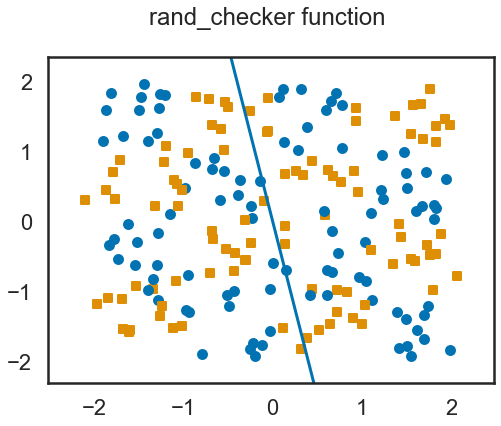

In [153]:
plot_2d(X_3, Y_3)
plt.plot(np.arange(-5, 4, 0.1)*0.5, np.arange(-5, 4, 0.1)*(-2.5))
plt.title("rand_checker function \n")

- $\hat\f(w)$ est grand lorsque $cos(x,w) = 1$ i.e [$0 ,\pi/2$] U [$3\pi/2 ,2\pi$]

- $\hat\f(w)$ est grand lorsque $cos(x,w) = -1$ i.e [$\pi/2\ ,-\pi/2$]

- $w_{0}$ correspond à l'odronnée à l'origine (intercept)

$\hat\f(w) = w_{0} + <x,w> = w_{0} + ||x||.||w||.cos(x,w)$ 

Cette fonction est donc un produit scalaire

#### Question 2

Vérifions que la fonction predict(x,w) revoi f chapeau

In [162]:
w = list()
for i in range (3):
    w.append(np.random.randint(0,50))
    
w

[12, 22, 25]

In [169]:
f_chapo_1 = predict(X_1, w)
f_chapo_1

array([-37.89327818, -32.52703285,  53.10878122, -40.19725872,
        57.53317081, -33.22216299,  59.86305725,  56.58209284,
        58.60887418, -32.15574362,  63.05213049, -38.14993484,
        56.62390227, -36.08766968,  61.59358679,  59.81375484,
       -31.54246298, -35.64623968, -35.03549587, -33.09444907,
        59.79869017,  62.64010639, -32.69772393,  61.54812704,
        64.87174963, -34.21298216, -35.08067526,  57.75458968,
       -31.37862003, -39.39172186, -38.74167703, -35.50797586,
        59.62101768, -36.88701731,  57.09323894,  55.24328408,
        62.20710923,  67.34156889, -34.67113555,  55.8944347 ,
       -35.09362159,  57.30049547, -35.87677761, -38.14951735,
       -43.01270876, -32.53197331, -31.67172573,  55.76404235,
        57.97230137,  58.51646622, -31.5785754 ,  59.62767645,
       -37.19602373, -32.18764106,  57.86929237, -33.67960489,
        55.91512603, -34.99346879, -34.7931145 ,  52.87693778,
       -29.00205999, -36.24646865,  60.7085635 , -42.88

In [170]:
f_chapo_1_label = predict_class(X_1, w)
f_chapo_1_label

array([-1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,
       -1.,  1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1., -1.,
       -1.,  1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
        1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,
       -1., -1.,  1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,
        1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1.,
        1., -1.,  1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1., -1.,
        1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,
        1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,
        1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,
        1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1., -1., -1.,  1., -1.,
        1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
        1.,  1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.,
       -1., -1., -1., -1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1

#### Affichage des labels des points d'observations

In [51]:
###############################################################################
#            Displaying labeled data
###############################################################################

symlist = ['o', 's', '+', 'x', 'D', '*', 'p', 'v', '-', '^']
collist = ['blue', 'red', 'purple', 'orange', 'salmon', 'black', 'grey',
           'fuchsia']


def plot_2d(X, y, w=None, step=50, alpha_choice=1):
    """2D dataset data ploting according to labels.

    Parameters
    ----------

    X : data features

    y : label vector

    w :(optional) the separating hyperplan w

    alpha_choice : control alpha display parameter
    """
    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    for i, label in enumerate(y):
        label_num = np.where(labels == label)[0][0]
        plt.scatter(X[i, 0], X[i, 1],
                    c=np.reshape(color_blind_list[label_num], (1, -1)),
                    s=80, marker=symlist[label_num])
    plt.xlim([min_tot0 - delta0 / 10., max_tot0 + delta0 / 10.])
    plt.ylim([min_tot1 - delta1 / 10., max_tot1 + delta1 / 10.])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)


#### Fonctions de pertes et leur gradient

In [54]:
###############################################################################
#               Loss functions and their gradient
###############################################################################

def predict(x, w):
    """Prediction from a normal vector."""
    return np.dot(x, w[1:]) + w[0]


def predict_class(x, w):
    """Predict a class from at point x thanks to a normal vector."""
    return np.sign(predict(x, w))


def zero_one_loss(x, y, w):
    """0-1 loss function."""
    return abs(y - np.sign(predict(x, w))) / 2.


def hinge_loss(x, y, w):
    """Hinge loss function."""
    return np.maximum(0., 1. - y * predict(x, w))


def mse_loss(x, y, w):
    """Mean square error loss."""
    return (y - predict(x, w)) ** 2


def norm2(x, y, w):
    """Squared norm of a vector."""
    return np.dot(w, w)


def gr_hinge_loss(x, y, w):
    """Sub-gradient of the loss function hingeloss."""
    return np.dot(-y * (hinge_loss(x, y, w) > 0.),
                  np.hstack((np.ones((x.shape[0], 1)), x)))


def gr_mse_loss(x, y, w):
    """Gradient of the least squares lost function."""
    return -2. * np.dot(y - predict(x, w),
                        np.hstack((np.ones((x.shape[0], 1)), x)))


def gr_norm2(x, y, w):
    """Gradient of the squared norm."""
    return 2. * w


def pen_loss_aux(x, y, w, l):
    """Loss function penalized by hinge loss."""
    return hinge_loss(x, y, w) + l * norm2(x, y, w)


def gr_pen_loss_aux(x, y, w, l):
    """Gradient of hinge loss penalized loss function."""
    return gr_hinge_loss(x, y, w) + l * gr_norm2(x, y, w, )


def pen_loss(l):
    """Penalized loss function."""
    return lambda x, y, w: pen_loss_aux(x, y, w, l)


def gr_pen_loss(l):
    """Gradient penalized loss function."""
    return lambda x, y, w: gr_pen_loss_aux(x, y, w, l)

#### Affichage de la frontière

In [55]:
###############################################################################
#            Displaying tools for the Frontiere
###############################################################################

def frontiere(f, X, step=50, cmap_choice=cm.coolwarm):
    """Frontiere plotting for a decision function f."""
    min_tot0 = np.min(X[:, 0])
    max_tot0 = np.max(X[:, 0])
    min_tot1 = np.min(X[:, 1])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    plt.imshow(z, origin='lower', interpolation="nearest", cmap=cmap_choice,
               extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    plt.colorbar()

def frontiere_new(clf, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True, n_labels=3, n_neighbors=3):
    """Trace la frontiere pour la fonction de decision de clf."""
    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    XX = np.c_[xx.ravel(), yy.ravel()]
    print(XX.shape)
    z = clf.predict(XX)
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    # color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    # sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[label_num]],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)
    plt.title("L=" + str(n_labels) + ",k=" +
              str(n_neighbors))

def frontiere_3d(f, data, step=20):
    """Plot the 3d frontiere for the decision function f."""
    ax = plt.gca(projection='3d')
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    ax.plot_surface(xx, yy, z, rstride=1, cstride=1,
                    linewidth=0., antialiased=False,
                    cmap=plt.cm.coolwarm)

def plot_cout(X, y, loss_fun, w=None):
    """Plot the cost function encoded by loss_fun,

    Parameters
    ----------
    X : data features
    y :  labels
    loss_fun : loss function
    w : (optionnal) can be used to give a historic path of the weights """
    def _inter(wn):
        ww = np.zeros(3)
        ww[1:] = wn
        return loss_fun(X, y, ww).mean()
    datarange = np.array([[np.min(X[:, 0]), np.min(X[:, 1])],
                          [np.max(X[:, 0]), np.max(X[:, 1])]])
    frontiere(_inter, np.array(datarange))
    if w is not None:
        plt.plot(w[:, 1], w[:, 2], 'k')
    plt.xlim([np.min(X[:, 0]), np.max(X[:, 0])])
    plt.ylim([np.min(X[:, 1]), np.max(X[:, 1])])

def plot_cout3d(x, y, loss_fun, w):
    """ trace le cout de la fonction cout loss_fun passee en parametre, en x,y,
        en faisant varier les coordonnees du poids w.
        W peut etre utilise pour passer un historique de poids"""
    def _inter(wn):
        ww = np.zeros(3)
        ww[1:] = wn
        return loss_fun(x, y, ww).mean()

    datarange = np.array([[w[:, 1].min(), w[:, 2].min()],
                         [w[:, 1].max(), w[:, 2].max()]])
    frontiere_3d(_inter, np.array(datarange))
    plt.plot(w[:, 1], w[:, 2], np.array([_inter(w[i, 1:]) for i in
             range(w.shape[0])]), 'k-', linewidth=3)


#### Algorithmes

In [ ]:
###############################################################################
#                Algorithms and functions
###############################################################################

def gradient(x, y, eps, niter, w_ini, loss_fun, gr_loss_fun, stochastic=True):
    """ algorithme de descente du gradient:
        - x : donnees
        - y : label
        - eps : facteur multiplicatif de descente
        - niter : nombre d'iterations
        - w_ini
        - loss_fun : fonction de cout
        - gr_loss_fun : gradient de la fonction de cout
        - stoch : True : gradient stochastique
        """
    w = np.zeros((niter, w_ini.size))
    w[0] = w_ini
    loss = np.zeros(niter)
    loss[0] = loss_fun(x, y, w[0]).mean()
    for i in range(1, niter):
        if stochastic:  # this is for Stochastic Gradient Descent
            idx = [np.random.randint(x.shape[0])]
        else:           # this is for pure Gradient Descent
            idx = np.arange(x.shape[0])
        w[i, :] = w[i - 1, :] - eps * gr_loss_fun(x[idx, :],
                                                  y[idx], w[i - 1, :])
        loss[i] = loss_fun(x, y, w[i, :]).mean()
    return w, loss

def plot_gradient(X, y, wh, cost_hist, loss_fun):
    """ display 4 figures on how  (stochastic) gradient descent behaves
    wh : solution history
    cost_hist : cost history
    loss_fun : loss function
    """
    best = np.argmin(cost_hist)
    plt.subplot(221)
    plt.title('Data and hyperplane estimated')
    plot_2d(X, y, wh[best, :])
    plt.subplot(222)
    plt.title('Projection of level line and algorithm path')
    plot_cout(X, y, loss_fun, wh)
    plt.subplot(223)
    plt.title('Objective function vs iterations')
    plt.plot(range(cost_hist.shape[0]), cost_hist)
    plt.subplot(224, projection='3d')
    plt.title('Level line and algorithm path')
    plot_cout3d(X, y, loss_fun, wh)


#### Polynomal transformations

In [45]:
###############################################################################
#                Polynomial transformations
###############################################################################

def poly2(x):
    """ creates features for second order interactions """
    if x.ndim == 1:
        x = x[None, :]
    nb, d = x.shape
    res = x
    for i in range(0, d):
        for j in range(i, d):
            res = np.hstack((res, x[:, i:i + 1] * x[:, j:j + 1]))
    return res

def poly3(x):
    """ creates features for third order interactions """
    if x.ndim == 1:
            x = x[None, :]
    nb, d = x.shape
    res = poly2(x)
    for i in range(0, d):
        for j in range(i, d):
            for k in range(j, d):
                res = np.hstack(
                    (res, x[:, i:i + 1] * x[:, j:j + 1] * x[:, k:k + 1]))
    return res